Load model
Colorizing the image


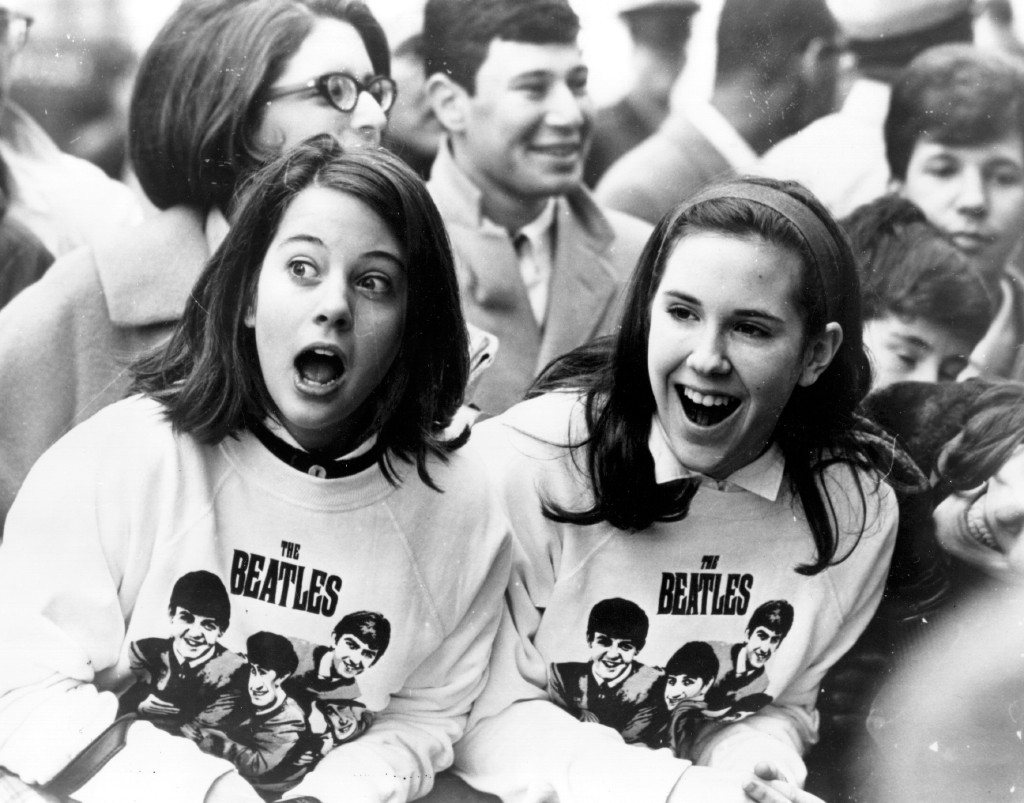

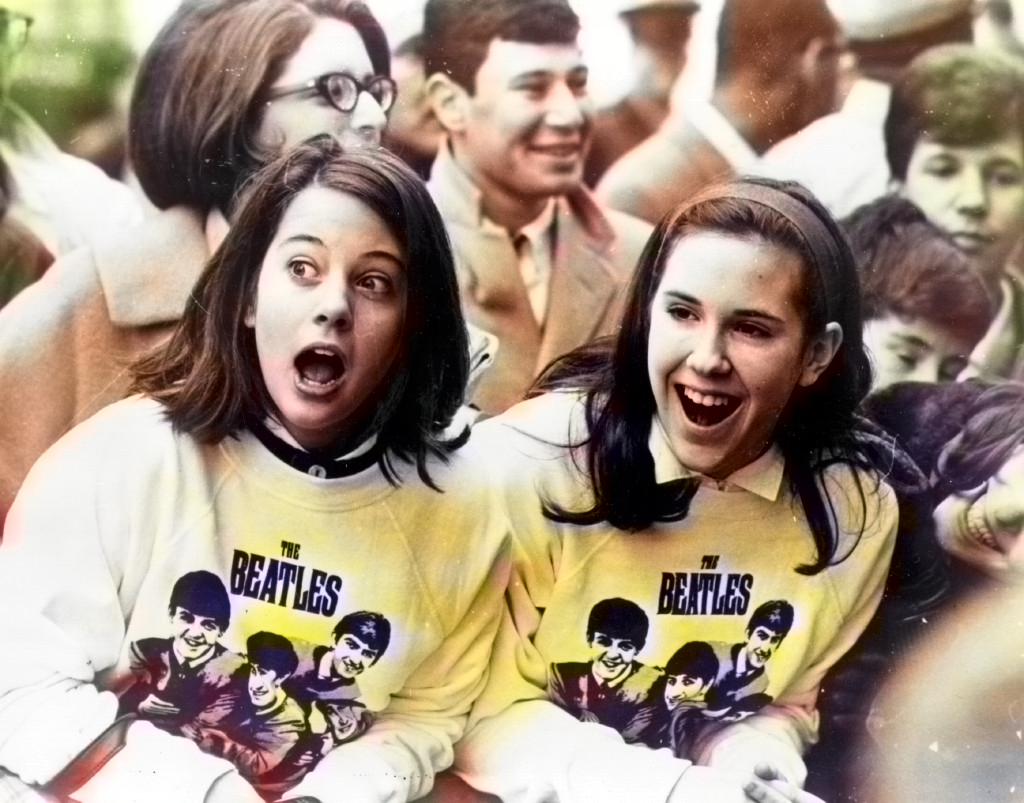

-1

In [ ]:
import numpy as np
import argparse
import cv2
import os

# Paths to load the model
DIR = r"/content/sample_data/imagecoloriser/another random pic.jpg"
PROTOTXT = os.path.join(DIR, r"/content/sample_data/imagecoloriser/colorization_deploy_v2.prototxt")
POINTS = os.path.join(DIR, r"/content/sample_data/imagecoloriser/pts_in_hull.npy")
MODEL = os.path.join(DIR, r"/content/sample_data/imagecoloriser/colorization_release_v2.caffemodel")

# Argparser
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", type=str, required=True,
help="path to input black and white image")
args = {"image": "/content/sample_data/imagecoloriser/another random pic.jpg"}

# Load the Model
print("Load model")
net = cv2.dnn.readNetFromCaffe(PROTOTXT, MODEL)
pts = np.load(POINTS)

# Load centers for ab channel quantization used for rebalancing.
class8 = net.getLayerId("class8_ab")
conv8 = net.getLayerId("conv8_313_rh")
pts = pts.transpose().reshape(2, 313, 1, 1)
net.getLayer(class8).blobs = [pts.astype("float32")]
net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]

# Load the input image
image = cv2.imread(args["image"])
scaled = image.astype("float32") / 255.0
lab = cv2.cvtColor(scaled, cv2.COLOR_BGR2LAB)

resized = cv2.resize(lab, (224, 224))
L = cv2.split(resized)[0]
L -= 50

print("Colorizing the image")
net.setInput(cv2.dnn.blobFromImage(L))
ab = net.forward()[0, :, :, :].transpose((1, 2, 0))

ab = cv2.resize(ab, (image.shape[1], image.shape[0]))

L = cv2.split(lab)[0]
colorized = np.concatenate((L[:, :, np.newaxis], ab), axis=2)

colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2BGR)
colorized = np.clip(colorized, 0, 1)

colorized = (255 * colorized).astype("uint8")
from google.colab.patches import cv2_imshow
cv2_imshow(image)
cv2_imshow(colorized)
cv2.waitKey(0)